# FIKH Model: Large Amplitude Oscillatory Shear (LAOS)

## Learning Objectives

1. Fit FIKH to **LAOS (large amplitude oscillatory)** experimental data
2. Analyze **Lissajous curves** (stress-strain loops) with fractional memory
3. Extract **Fourier harmonics** and understand nonlinear contributions
4. Explore how **alpha_structure** affects intra-cycle structure evolution
5. Quantify yielding and thixotropy during oscillatory flow

## Prerequisites

- NB01: FIKH Flow Curve (concepts)
- NB05: FIKH SAOS (linear viscoelasticity)
- Bayesian inference fundamentals

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~5-8 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~20-30 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_pnas_laos,
    save_fikh_results,
    print_convergence_summary,
    print_parameter_comparison,
    compute_fit_quality,
    get_fikh_param_names,
    print_alpha_interpretation,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: Fractional LAOS Response

In LAOS, the strain amplitude is large enough to probe **nonlinear** material response:
$$
\gamma(t) = \gamma_0 \sin(\omega t)
$$

### Nonlinear Features

1. **Lissajous curves**: Non-elliptical stress-strain loops
2. **Higher harmonics**: $\sigma(t) = \sum_n (G'_n \sin(n\omega t) + G''_n \cos(n\omega t))$
3. **Intra-cycle yielding**: Structure breakdown within each cycle

### Alpha Effect on LAOS

- **Lower alpha**: Memory effects persist across cycles, slower equilibration
- **Higher alpha**: Each cycle approaches independent behavior

### Key Indicators

- **e₃/e₁ ratio**: Measure of nonlinearity (zero for linear response)
- **Lissajous shape**: Rhomboidal (thixotropic), rectangular (yield stress)

## 3. Load Data

In [3]:
# Load PNAS LAOS data
OMEGA = 1.0  # rad/s
STRAIN_AMP_INDEX = 5  # Medium amplitude

time_data, strain_data, stress_data = load_pnas_laos(
    omega=OMEGA,
    strain_amplitude_index=STRAIN_AMP_INDEX,
)

# Estimate strain amplitude from data
gamma_0 = (np.max(strain_data) - np.min(strain_data)) / 2

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Strain amplitude: {gamma_0:.4f}")
print(f"Angular frequency: {OMEGA} rad/s")

Data points: 1000
Time range: [0.0053, 66.00] s
Strain amplitude: 0.5120
Angular frequency: 1.0 rad/s


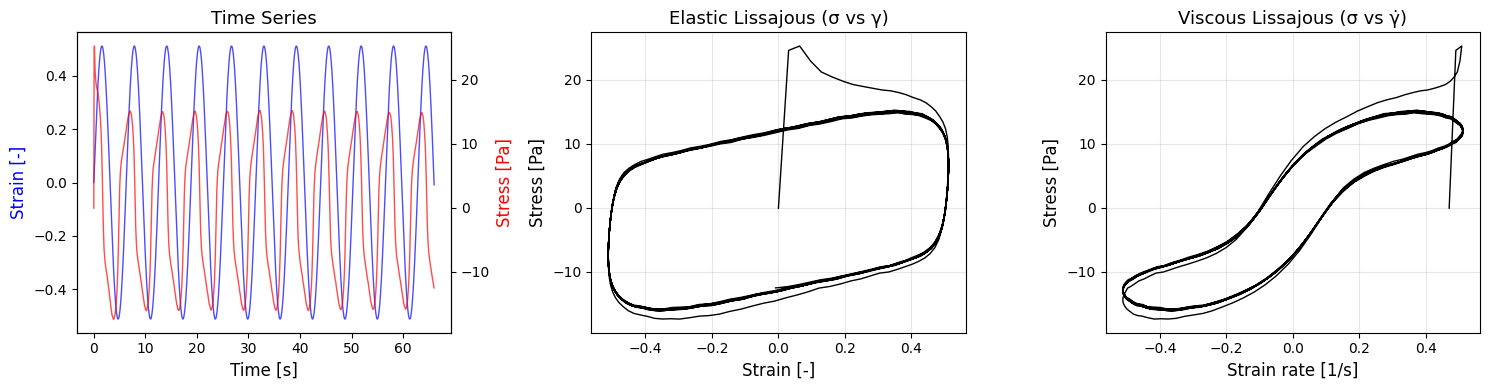

In [4]:
# Plot raw LAOS data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Time series
ax1 = axes[0]
ax1.plot(time_data, strain_data, "b-", lw=1, alpha=0.7, label="Strain")
ax1_twin = ax1.twinx()
ax1_twin.plot(time_data, stress_data, "r-", lw=1, alpha=0.7, label="Stress")
ax1.set_xlabel("Time [s]", fontsize=12)
ax1.set_ylabel("Strain [-]", fontsize=12, color="blue")
ax1_twin.set_ylabel("Stress [Pa]", fontsize=12, color="red")
ax1.set_title("Time Series", fontsize=13)

# Lissajous curve (elastic)
ax2 = axes[1]
ax2.plot(strain_data, stress_data, "k-", lw=1)
ax2.set_xlabel("Strain [-]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Elastic Lissajous (σ vs γ)", fontsize=13)
ax2.grid(True, alpha=0.3)

# Lissajous curve (viscous)
gamma_dot_data = np.gradient(strain_data, time_data)
ax3 = axes[2]
ax3.plot(gamma_dot_data, stress_data, "k-", lw=1)
ax3.set_xlabel("Strain rate [1/s]", fontsize=12)
ax3.set_ylabel("Stress [Pa]", fontsize=12)
ax3.set_title("Viscous Lissajous (σ vs γ̇)", fontsize=13)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit FIKH model
model = FIKH(include_thermal=False, alpha_structure=0.7)

t0 = time.time()
model.fit(time_data, stress_data, test_mode="laos", strain=strain_data, method='scipy')
t_nlsq = time.time() - t0

param_names = get_fikh_param_names(include_thermal=False)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fikh.py", line 467, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ fit time: 0.69 s

Fitted parameters:
  G               = 9.81
  eta             = 394.8
  C               = 452.2
  gamma_dyn       = 11.16
  m               = 1.031
  sigma_y0        = 9.583
  delta_sigma_y   = 53.07
  tau_thix        = 62.58
  Gamma           = 93.37
  alpha_structure = 0.7321
  eta_inf         = 29.21
  mu_p            = 0.001


In [6]:
# Predict LAOS response using predict_laos() which returns a dictionary
laos_result = model.predict_laos(time_data, gamma_0=gamma_0, omega=OMEGA)
stress_pred = np.asarray(laos_result["stress"])

metrics = compute_fit_quality(stress_data, stress_pred)
print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")


Fit Quality:
  R^2:   0.955665
  RMSE:  2.442 Pa


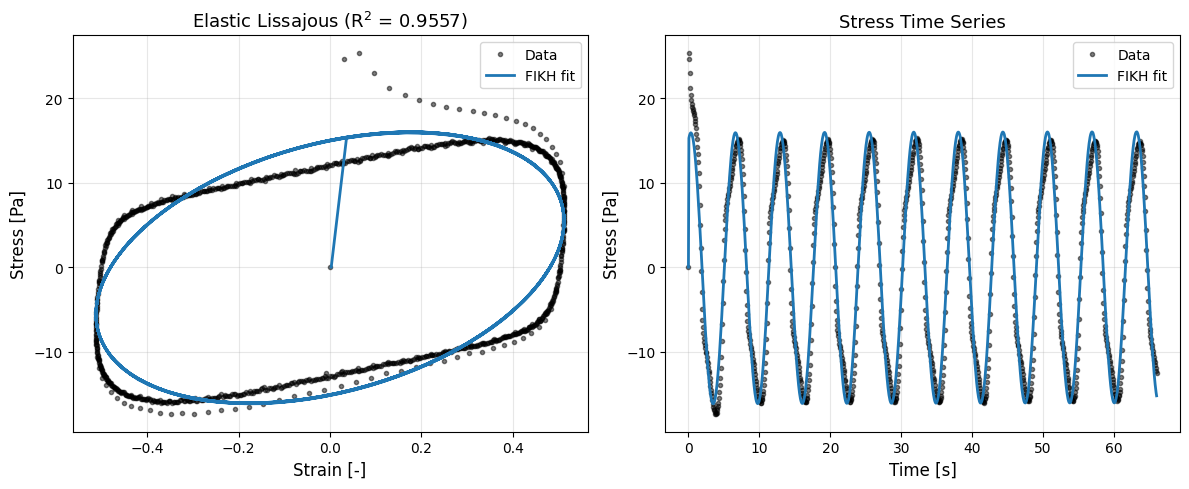

In [7]:
# Plot fit: Lissajous curves
strain_pred = np.asarray(laos_result["strain"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Elastic Lissajous
ax1.plot(strain_data, stress_data, "ko", markersize=3, alpha=0.5, label="Data")
ax1.plot(strain_pred, stress_pred, "-", lw=2, color="C0", label="FIKH fit")
ax1.set_xlabel("Strain [-]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title(f"Elastic Lissajous (R$^2$ = {metrics['R2']:.4f})", fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Time series comparison
ax2.plot(time_data, stress_data, "ko", markersize=3, alpha=0.5, label="Data")
ax2.plot(time_data, stress_pred, "-", lw=2, color="C0", label="FIKH fit")
ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("Stress Time Series", fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Alpha Effect on LAOS

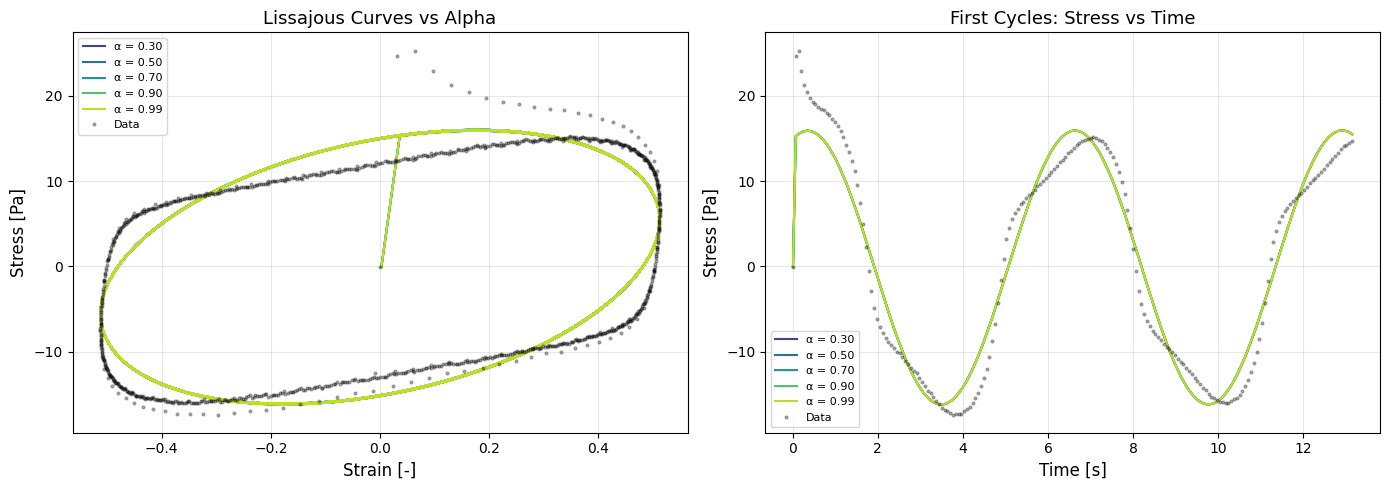

In [8]:
# Compare Lissajous curves for different alpha values
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(alpha_values)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

original_alpha = model.parameters.get_value("alpha_structure")

for alpha, color in zip(alpha_values, colors):
    model.parameters.set_value("alpha_structure", alpha)
    result = model.predict_laos(time_data, gamma_0=gamma_0, omega=OMEGA)
    stress_alpha = np.asarray(result["stress"])
    strain_alpha = np.asarray(result["strain"])
    
    ax1.plot(strain_alpha, stress_alpha, "-", color=color, lw=1.5, label=f"α = {alpha:.2f}")
    ax2.plot(time_data[:200], stress_alpha[:200], "-", color=color, lw=1.5, label=f"α = {alpha:.2f}")

model.parameters.set_value("alpha_structure", original_alpha)

# Add data
ax1.plot(strain_data, stress_data, "ko", markersize=2, alpha=0.3, label="Data")
ax2.plot(time_data[:200], stress_data[:200], "ko", markersize=2, alpha=0.3, label="Data")

ax1.set_xlabel("Strain [-]", fontsize=12)
ax1.set_ylabel("Stress [Pa]", fontsize=12)
ax1.set_title("Lissajous Curves vs Alpha", fontsize=13)
ax1.legend(fontsize=8, loc="best")
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Time [s]", fontsize=12)
ax2.set_ylabel("Stress [Pa]", fontsize=12)
ax2.set_title("First Cycles: Stress vs Time", fontsize=13)
ax2.legend(fontsize=8, loc="best")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

In [9]:
# Physical interpretation
fitted_alpha = model.parameters.get_value("alpha_structure")
print_alpha_interpretation(fitted_alpha)

Fractional Order Interpretation: α = 0.732

Regime: Weak Memory

Approaching classical behavior with mild power-law tails.
Recovery is mostly exponential with slow corrections.
Suitable for: Mildly thixotropic materials.

Physical Implications:
  • Memory kernel decay: t^(-0.73)
  • Recovery time scale: > τ_thix × Γ(1+0.73) = 0.92 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.73


## 6. Fourier Harmonic Analysis

In [10]:
# Extract Fourier harmonics from LAOS response
def extract_harmonics(time, stress, omega, n_harmonics=5):
    """Extract Fourier harmonics from LAOS stress response."""
    period = 2 * np.pi / omega
    n_cycles = int(time[-1] / period)
    
    # Use last 2 cycles for steady-state
    if n_cycles >= 2:
        start_idx = int(len(time) * (n_cycles - 2) / n_cycles)
    else:
        start_idx = 0
    
    t_ss = time[start_idx:]
    stress_ss = stress[start_idx:]
    
    harmonics = {}
    for n in range(1, n_harmonics + 1):
        # Integrate: e_n = (2/T) ∫ σ(t) sin(nωt) dt
        # v_n = (2/T) ∫ σ(t) cos(nωt) dt
        sin_term = np.sin(n * omega * t_ss)
        cos_term = np.cos(n * omega * t_ss)
        
        e_n = 2 * np.trapezoid(stress_ss * sin_term, t_ss) / (t_ss[-1] - t_ss[0])
        v_n = 2 * np.trapezoid(stress_ss * cos_term, t_ss) / (t_ss[-1] - t_ss[0])
        
        harmonics[f"e_{n}"] = e_n
        harmonics[f"v_{n}"] = v_n
    
    return harmonics

# Extract harmonics from data and fit
harmonics_data = extract_harmonics(time_data, stress_data, OMEGA)
harmonics_fit = extract_harmonics(time_data, stress_pred, OMEGA)

print("Fourier Harmonic Comparison:")
print("=" * 50)
print(f"{'Harmonic':>10s}  {'Data':>12s}  {'FIKH':>12s}")
print("-" * 50)
for key in harmonics_data:
    print(f"{key:>10s}  {harmonics_data[key]:12.4g}  {harmonics_fit[key]:12.4g}")

# Nonlinearity indicator
e3_e1_data = abs(harmonics_data["e_3"]) / (abs(harmonics_data["e_1"]) + 1e-10)
e3_e1_fit = abs(harmonics_fit["e_3"]) / (abs(harmonics_fit["e_1"]) + 1e-10)
print(f"\nNonlinearity (|e₃/e₁|): Data = {e3_e1_data:.4f}, FIKH = {e3_e1_fit:.4f}")

Fourier Harmonic Comparison:
  Harmonic          Data          FIKH
--------------------------------------------------
       e_1         5.051             5
       v_1         14.93          15.5
       e_2        0.4153        0.5079
       v_2       -0.8285       -0.9592
       e_3       -0.9666        -0.672
       v_3        -2.175         0.752
       e_4        0.6594        0.7474
       v_4       -0.4276       -0.5133
       e_5       -0.1371       -0.7333
       v_5         1.004         0.281

Nonlinearity (|e₃/e₁|): Data = 0.1914, FIKH = 0.1344


## 7. Bayesian Inference

In [11]:
# Bayesian inference
initial_values = {name: model.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    time_data,
    stress_data,
    test_mode="laos",
    strain=strain_data,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<06:03,  1.92it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 5/700 [00:00<01:12,  9.58it/s, 7 steps of size 1.51e-03. acc. prob=0.40]

warmup:   1%|          | 7/700 [00:00<01:03, 10.86it/s, 15 steps of size 1.08e-03. acc. prob=0.57]

warmup:   1%|▏         | 9/700 [00:01<01:21,  8.44it/s, 15 steps of size 1.00e-03. acc. prob=0.67]

warmup:   2%|▏         | 11/700 [00:09<16:18,  1.42s/it, 1023 steps of size 1.07e-03. acc. prob=0.73]

warmup:   2%|▏         | 12/700 [00:20<37:05,  3.24s/it, 1023 steps of size 1.13e-03. acc. prob=0.75]

warmup:   2%|▏         | 13/700 [00:31<58:10,  5.08s/it, 1023 steps of size 1.22e-03. acc. prob=0.77]

warmup:   2%|▏         | 14/700 [00:42<1:13:54,  6.46s/it, 1023 steps of size 1.32e-03. acc. prob=0.79]

warmup:   2%|▏         | 15/700 [00:53<1:25:03,  7.45s/it, 1023 steps of size 1.43e-03. acc. prob=0.80]

warmup:   2%|▏         | 16/700 [01:00<1:25:07,  7.47s/it, 1023 steps of size 1.52e-03. acc. prob=0.81]

warmup:   2%|▏         | 17/700 [01:10<1:33:15,  8.19s/it, 1023 steps of size 1.67e-03. acc. prob=0.82]

warmup:   3%|▎         | 18/700 [01:21<1:39:54,  8.79s/it, 1023 steps of size 1.84e-03. acc. prob=0.83]

warmup:   3%|▎         | 19/700 [01:29<1:37:06,  8.56s/it, 1023 steps of size 2.00e-03. acc. prob=0.84]

warmup:   3%|▎         | 20/700 [01:36<1:34:25,  8.33s/it, 1023 steps of size 2.20e-03. acc. prob=0.85]

warmup:   3%|▎         | 21/700 [01:47<1:40:37,  8.89s/it, 1023 steps of size 2.43e-03. acc. prob=0.86]

warmup:   3%|▎         | 22/700 [01:57<1:45:05,  9.30s/it, 1023 steps of size 2.55e-03. acc. prob=0.86]

warmup:   3%|▎         | 23/700 [02:04<1:39:17,  8.80s/it, 1023 steps of size 2.81e-03. acc. prob=0.87]

warmup:   3%|▎         | 24/700 [02:12<1:34:52,  8.42s/it, 1023 steps of size 3.06e-03. acc. prob=0.87]

warmup:   4%|▎         | 25/700 [02:24<1:46:55,  9.50s/it, 1023 steps of size 3.34e-03. acc. prob=0.88]

warmup:   4%|▎         | 26/700 [02:36<1:56:01, 10.33s/it, 1023 steps of size 3.65e-03. acc. prob=0.88]

warmup:   4%|▍         | 27/700 [02:47<1:57:15, 10.45s/it, 1023 steps of size 3.99e-03. acc. prob=0.89]

warmup:   4%|▍         | 28/700 [02:58<1:57:34, 10.50s/it, 1023 steps of size 4.21e-03. acc. prob=0.89]

warmup:   4%|▍         | 29/700 [03:09<1:59:54, 10.72s/it, 1023 steps of size 4.19e-03. acc. prob=0.89]

warmup:   4%|▍         | 30/700 [03:21<2:03:00, 11.02s/it, 1023 steps of size 4.56e-03. acc. prob=0.90]

warmup:   4%|▍         | 31/700 [03:33<2:07:01, 11.39s/it, 1023 steps of size 4.74e-03. acc. prob=0.90]

warmup:   5%|▍         | 32/700 [03:44<2:07:19, 11.44s/it, 1023 steps of size 4.97e-03. acc. prob=0.90]

warmup:   5%|▍         | 33/700 [03:52<1:54:05, 10.26s/it, 1023 steps of size 5.43e-03. acc. prob=0.90]

warmup:   5%|▍         | 34/700 [04:02<1:52:56, 10.17s/it, 1023 steps of size 5.22e-03. acc. prob=0.91]

warmup:   5%|▌         | 35/700 [04:09<1:43:41,  9.36s/it, 1023 steps of size 5.32e-03. acc. prob=0.91]

warmup:   5%|▌         | 36/700 [04:20<1:46:35,  9.63s/it, 1023 steps of size 5.49e-03. acc. prob=0.91]

warmup:   5%|▌         | 37/700 [04:29<1:45:37,  9.56s/it, 1023 steps of size 3.45e-03. acc. prob=0.91]

warmup:   5%|▌         | 38/700 [04:41<1:53:16, 10.27s/it, 1023 steps of size 3.73e-03. acc. prob=0.91]

warmup:   6%|▌         | 39/700 [04:49<1:44:32,  9.49s/it, 1023 steps of size 3.81e-03. acc. prob=0.91]

warmup:   6%|▌         | 40/700 [04:59<1:46:28,  9.68s/it, 1023 steps of size 4.14e-03. acc. prob=0.91]

warmup:   6%|▌         | 41/700 [05:06<1:39:18,  9.04s/it, 1023 steps of size 4.48e-03. acc. prob=0.92]

warmup:   6%|▌         | 42/700 [05:17<1:43:37,  9.45s/it, 1023 steps of size 4.84e-03. acc. prob=0.92]

warmup:   6%|▌         | 43/700 [05:27<1:47:03,  9.78s/it, 1023 steps of size 4.88e-03. acc. prob=0.92]

warmup:   6%|▋         | 44/700 [05:34<1:38:29,  9.01s/it, 1023 steps of size 4.90e-03. acc. prob=0.92]

warmup:   6%|▋         | 45/700 [05:45<1:42:35,  9.40s/it, 1023 steps of size 5.18e-03. acc. prob=0.92]

warmup:   7%|▋         | 46/700 [05:55<1:45:14,  9.66s/it, 1023 steps of size 5.25e-03. acc. prob=0.92]

warmup:   7%|▋         | 47/700 [06:02<1:37:35,  8.97s/it, 1023 steps of size 5.40e-03. acc. prob=0.92]

warmup:   7%|▋         | 48/700 [06:10<1:33:07,  8.57s/it, 1023 steps of size 5.35e-03. acc. prob=0.92]

warmup:   7%|▋         | 49/700 [06:17<1:28:20,  8.14s/it, 1023 steps of size 4.48e-03. acc. prob=0.92]

warmup:   7%|▋         | 50/700 [06:27<1:34:20,  8.71s/it, 1023 steps of size 4.81e-03. acc. prob=0.93]

warmup:   7%|▋         | 51/700 [06:38<1:40:40,  9.31s/it, 1023 steps of size 5.06e-03. acc. prob=0.93]

warmup:   7%|▋         | 52/700 [06:48<1:43:25,  9.58s/it, 1023 steps of size 4.99e-03. acc. prob=0.93]

warmup:   8%|▊         | 53/700 [06:56<1:36:39,  8.96s/it, 1023 steps of size 5.36e-03. acc. prob=0.93]

warmup:   8%|▊         | 54/700 [07:05<1:38:55,  9.19s/it, 1023 steps of size 5.07e-03. acc. prob=0.93]

warmup:   8%|▊         | 55/700 [07:12<1:31:40,  8.53s/it, 1023 steps of size 5.34e-03. acc. prob=0.93]

warmup:   8%|▊         | 56/700 [07:22<1:36:28,  8.99s/it, 1023 steps of size 5.72e-03. acc. prob=0.93]

warmup:   8%|▊         | 57/700 [07:32<1:39:46,  9.31s/it, 1023 steps of size 6.10e-03. acc. prob=0.93]

warmup:   8%|▊         | 58/700 [07:42<1:41:47,  9.51s/it, 1023 steps of size 6.45e-03. acc. prob=0.93]

warmup:   8%|▊         | 59/700 [07:50<1:34:43,  8.87s/it, 1023 steps of size 6.88e-03. acc. prob=0.93]

warmup:   9%|▊         | 60/700 [07:57<1:29:38,  8.40s/it, 1023 steps of size 5.43e-03. acc. prob=0.93]

warmup:   9%|▊         | 61/700 [08:09<1:39:28,  9.34s/it, 1023 steps of size 5.80e-03. acc. prob=0.93]

warmup:   9%|▉         | 62/700 [08:16<1:33:51,  8.83s/it, 1023 steps of size 5.13e-03. acc. prob=0.93]

warmup:   9%|▉         | 63/700 [08:24<1:29:28,  8.43s/it, 1023 steps of size 5.43e-03. acc. prob=0.94]

warmup:   9%|▉         | 64/700 [08:31<1:27:05,  8.22s/it, 1023 steps of size 5.47e-03. acc. prob=0.94]

warmup:   9%|▉         | 65/700 [08:42<1:32:58,  8.78s/it, 1023 steps of size 5.77e-03. acc. prob=0.94]

warmup:   9%|▉         | 66/700 [08:52<1:37:15,  9.20s/it, 1023 steps of size 5.37e-03. acc. prob=0.94]

warmup:  10%|▉         | 67/700 [09:02<1:41:41,  9.64s/it, 1023 steps of size 5.60e-03. acc. prob=0.94]

warmup:  10%|▉         | 68/700 [09:12<1:41:38,  9.65s/it, 1023 steps of size 5.95e-03. acc. prob=0.94]

warmup:  10%|▉         | 69/700 [09:22<1:41:33,  9.66s/it, 1023 steps of size 5.02e-03. acc. prob=0.94]

warmup:  10%|█         | 70/700 [09:32<1:41:38,  9.68s/it, 1023 steps of size 5.34e-03. acc. prob=0.94]

warmup:  10%|█         | 71/700 [09:42<1:43:41,  9.89s/it, 1023 steps of size 5.32e-03. acc. prob=0.94]

warmup:  10%|█         | 72/700 [09:52<1:45:01, 10.03s/it, 1023 steps of size 4.50e-03. acc. prob=0.94]

warmup:  10%|█         | 73/700 [10:02<1:45:13, 10.07s/it, 1023 steps of size 4.64e-03. acc. prob=0.94]

warmup:  11%|█         | 74/700 [10:12<1:43:56,  9.96s/it, 1023 steps of size 4.92e-03. acc. prob=0.94]

warmup:  11%|█         | 75/700 [10:20<1:38:18,  9.44s/it, 1023 steps of size 5.04e-03. acc. prob=0.94]

warmup:  11%|█         | 76/700 [10:31<1:41:02,  9.72s/it, 1023 steps of size 5.19e-03. acc. prob=0.94]

warmup:  11%|█         | 77/700 [10:41<1:42:15,  9.85s/it, 1023 steps of size 5.42e-03. acc. prob=0.94]

warmup:  11%|█         | 78/700 [10:51<1:43:34,  9.99s/it, 1023 steps of size 5.61e-03. acc. prob=0.94]

warmup:  11%|█▏        | 79/700 [11:01<1:42:16,  9.88s/it, 1023 steps of size 5.92e-03. acc. prob=0.94]

warmup:  11%|█▏        | 80/700 [11:11<1:42:38,  9.93s/it, 1023 steps of size 5.69e-03. acc. prob=0.94]

warmup:  12%|█▏        | 81/700 [11:19<1:37:10,  9.42s/it, 1023 steps of size 5.82e-03. acc. prob=0.94]

warmup:  12%|█▏        | 82/700 [11:30<1:40:51,  9.79s/it, 1023 steps of size 6.12e-03. acc. prob=0.94]

warmup:  12%|█▏        | 83/700 [11:37<1:33:56,  9.13s/it, 1023 steps of size 5.09e-03. acc. prob=0.94]

warmup:  12%|█▏        | 84/700 [11:45<1:28:40,  8.64s/it, 1023 steps of size 5.34e-03. acc. prob=0.94]

warmup:  12%|█▏        | 85/700 [11:53<1:27:57,  8.58s/it, 1023 steps of size 4.92e-03. acc. prob=0.94]

warmup:  12%|█▏        | 86/700 [12:04<1:33:12,  9.11s/it, 1023 steps of size 5.09e-03. acc. prob=0.94]

warmup:  12%|█▏        | 87/700 [12:11<1:28:02,  8.62s/it, 1023 steps of size 4.74e-03. acc. prob=0.94]

warmup:  13%|█▎        | 88/700 [12:19<1:24:58,  8.33s/it, 1023 steps of size 5.00e-03. acc. prob=0.94]

warmup:  13%|█▎        | 89/700 [12:30<1:33:15,  9.16s/it, 1023 steps of size 5.04e-03. acc. prob=0.95]

warmup:  13%|█▎        | 90/700 [12:40<1:37:24,  9.58s/it, 1023 steps of size 5.31e-03. acc. prob=0.95]

warmup:  13%|█▎        | 91/700 [12:51<1:39:53,  9.84s/it, 1023 steps of size 5.56e-03. acc. prob=0.95]

warmup:  13%|█▎        | 92/700 [12:59<1:35:38,  9.44s/it, 1023 steps of size 5.42e-03. acc. prob=0.95]

warmup:  13%|█▎        | 93/700 [13:09<1:36:57,  9.58s/it, 1023 steps of size 5.67e-03. acc. prob=0.95]

warmup:  13%|█▎        | 94/700 [13:17<1:30:29,  8.96s/it, 1023 steps of size 5.47e-03. acc. prob=0.95]

warmup:  14%|█▎        | 95/700 [13:24<1:26:16,  8.56s/it, 1023 steps of size 5.62e-03. acc. prob=0.95]

warmup:  14%|█▎        | 96/700 [13:32<1:22:17,  8.18s/it, 1023 steps of size 5.36e-03. acc. prob=0.95]

warmup:  14%|█▍        | 97/700 [13:39<1:19:47,  7.94s/it, 1023 steps of size 5.56e-03. acc. prob=0.95]

warmup:  14%|█▍        | 98/700 [13:50<1:27:28,  8.72s/it, 1023 steps of size 5.82e-03. acc. prob=0.95]

warmup:  14%|█▍        | 99/700 [14:01<1:35:34,  9.54s/it, 1023 steps of size 5.97e-03. acc. prob=0.95]

warmup:  14%|█▍        | 100/700 [14:11<1:37:56,  9.79s/it, 1023 steps of size 4.27e-03. acc. prob=0.95]

warmup:  14%|█▍        | 101/700 [14:23<1:43:13, 10.34s/it, 1023 steps of size 4.35e-02. acc. prob=0.95]

warmup:  15%|█▍        | 102/700 [14:23<1:13:15,  7.35s/it, 63 steps of size 4.47e-02. acc. prob=0.95]  

warmup:  15%|█▍        | 103/700 [14:24<53:15,  5.35s/it, 63 steps of size 4.60e-02. acc. prob=0.95]  

warmup:  15%|█▍        | 104/700 [14:25<38:32,  3.88s/it, 63 steps of size 4.73e-02. acc. prob=0.95]

warmup:  15%|█▌        | 105/700 [14:25<28:19,  2.86s/it, 63 steps of size 4.90e-02. acc. prob=0.95]

warmup:  15%|█▌        | 106/700 [14:26<22:34,  2.28s/it, 127 steps of size 5.07e-02. acc. prob=0.95]

warmup:  15%|█▌        | 107/700 [14:26<17:00,  1.72s/it, 63 steps of size 5.23e-02. acc. prob=0.95] 

warmup:  15%|█▌        | 108/700 [14:27<13:10,  1.33s/it, 63 steps of size 5.39e-02. acc. prob=0.95]

warmup:  16%|█▌        | 109/700 [14:27<10:09,  1.03s/it, 63 steps of size 5.57e-02. acc. prob=0.95]

warmup:  16%|█▌        | 110/700 [14:28<08:26,  1.16it/s, 63 steps of size 5.74e-02. acc. prob=0.95]

warmup:  16%|█▌        | 111/700 [14:28<07:10,  1.37it/s, 63 steps of size 5.89e-02. acc. prob=0.95]

warmup:  16%|█▌        | 112/700 [14:28<06:07,  1.60it/s, 63 steps of size 6.07e-02. acc. prob=0.95]

warmup:  16%|█▌        | 113/700 [14:29<05:35,  1.75it/s, 63 steps of size 6.22e-02. acc. prob=0.95]

warmup:  16%|█▋        | 114/700 [14:30<06:52,  1.42it/s, 127 steps of size 6.35e-02. acc. prob=0.95]

warmup:  16%|█▋        | 115/700 [14:30<06:15,  1.56it/s, 63 steps of size 6.51e-02. acc. prob=0.95] 

warmup:  17%|█▋        | 116/700 [14:31<04:59,  1.95it/s, 31 steps of size 6.66e-02. acc. prob=0.95]

warmup:  17%|█▋        | 117/700 [14:31<05:15,  1.85it/s, 63 steps of size 6.83e-02. acc. prob=0.95]

warmup:  17%|█▋        | 118/700 [14:32<04:42,  2.06it/s, 63 steps of size 7.01e-02. acc. prob=0.96]

warmup:  17%|█▋        | 119/700 [14:32<04:23,  2.21it/s, 63 steps of size 7.20e-02. acc. prob=0.96]

warmup:  17%|█▋        | 120/700 [14:32<03:54,  2.47it/s, 63 steps of size 7.39e-02. acc. prob=0.96]

warmup:  17%|█▋        | 121/700 [14:33<04:17,  2.25it/s, 63 steps of size 7.56e-02. acc. prob=0.96]

warmup:  17%|█▋        | 122/700 [14:33<04:13,  2.28it/s, 63 steps of size 7.74e-02. acc. prob=0.96]

warmup:  18%|█▊        | 123/700 [14:34<04:12,  2.29it/s, 63 steps of size 7.92e-02. acc. prob=0.96]

warmup:  18%|█▊        | 124/700 [14:34<03:47,  2.53it/s, 63 steps of size 8.08e-02. acc. prob=0.96]

warmup:  18%|█▊        | 125/700 [14:34<03:41,  2.59it/s, 63 steps of size 8.27e-02. acc. prob=0.96]

warmup:  18%|█▊        | 126/700 [14:35<03:25,  2.79it/s, 63 steps of size 8.43e-02. acc. prob=0.96]

warmup:  18%|█▊        | 127/700 [14:35<02:53,  3.29it/s, 31 steps of size 8.61e-02. acc. prob=0.96]

warmup:  18%|█▊        | 128/700 [14:35<03:15,  2.93it/s, 63 steps of size 8.77e-02. acc. prob=0.96]

warmup:  18%|█▊        | 129/700 [14:36<03:36,  2.63it/s, 63 steps of size 8.93e-02. acc. prob=0.96]

warmup:  19%|█▊        | 130/700 [14:36<03:05,  3.07it/s, 31 steps of size 9.03e-02. acc. prob=0.96]

warmup:  19%|█▊        | 131/700 [14:36<02:47,  3.39it/s, 31 steps of size 9.19e-02. acc. prob=0.96]

warmup:  19%|█▉        | 132/700 [14:36<02:44,  3.45it/s, 63 steps of size 9.36e-02. acc. prob=0.96]

warmup:  19%|█▉        | 133/700 [14:37<02:56,  3.21it/s, 63 steps of size 9.47e-02. acc. prob=0.96]

warmup:  19%|█▉        | 134/700 [14:37<03:20,  2.82it/s, 63 steps of size 9.59e-02. acc. prob=0.96]

warmup:  19%|█▉        | 135/700 [14:38<03:36,  2.60it/s, 63 steps of size 9.63e-02. acc. prob=0.96]

warmup:  19%|█▉        | 136/700 [14:38<03:11,  2.95it/s, 31 steps of size 9.82e-02. acc. prob=0.96]

warmup:  20%|█▉        | 137/700 [14:38<03:12,  2.92it/s, 31 steps of size 9.74e-02. acc. prob=0.96]

warmup:  20%|█▉        | 138/700 [14:39<03:23,  2.76it/s, 63 steps of size 9.92e-02. acc. prob=0.96]

warmup:  20%|█▉        | 139/700 [14:39<03:39,  2.55it/s, 63 steps of size 1.01e-01. acc. prob=0.96]

warmup:  20%|██        | 140/700 [14:39<03:01,  3.09it/s, 31 steps of size 1.03e-01. acc. prob=0.96]

warmup:  20%|██        | 141/700 [14:40<03:38,  2.56it/s, 63 steps of size 1.02e-01. acc. prob=0.96]

warmup:  20%|██        | 142/700 [14:40<04:08,  2.24it/s, 63 steps of size 1.03e-01. acc. prob=0.96]

warmup:  20%|██        | 143/700 [14:41<03:20,  2.77it/s, 31 steps of size 1.05e-01. acc. prob=0.96]

warmup:  21%|██        | 144/700 [14:41<02:43,  3.39it/s, 31 steps of size 1.05e-01. acc. prob=0.96]

warmup:  21%|██        | 145/700 [14:41<02:20,  3.96it/s, 31 steps of size 1.06e-01. acc. prob=0.96]

warmup:  21%|██        | 146/700 [14:41<03:18,  2.79it/s, 63 steps of size 1.08e-01. acc. prob=0.96]

warmup:  21%|██        | 147/700 [14:42<03:57,  2.33it/s, 63 steps of size 1.10e-01. acc. prob=0.96]

warmup:  21%|██        | 148/700 [14:42<03:09,  2.91it/s, 31 steps of size 1.10e-01. acc. prob=0.96]

warmup:  21%|██▏       | 149/700 [14:42<02:39,  3.46it/s, 31 steps of size 1.07e-01. acc. prob=0.96]

warmup:  21%|██▏       | 150/700 [14:42<02:14,  4.08it/s, 31 steps of size 1.08e-01. acc. prob=0.96]

warmup:  22%|██▏       | 151/700 [14:43<02:07,  4.30it/s, 31 steps of size 1.09e+00. acc. prob=0.96]

warmup:  22%|██▏       | 153/700 [14:43<01:59,  4.59it/s, 31 steps of size 9.30e-02. acc. prob=0.96]

warmup:  22%|██▏       | 154/700 [14:43<01:47,  5.08it/s, 31 steps of size 7.72e-02. acc. prob=0.96]

warmup:  22%|██▏       | 155/700 [14:44<02:12,  4.10it/s, 63 steps of size 7.00e-02. acc. prob=0.96]

warmup:  22%|██▏       | 156/700 [14:44<02:30,  3.62it/s, 63 steps of size 6.69e-02. acc. prob=0.96]

warmup:  22%|██▏       | 157/700 [14:44<02:42,  3.34it/s, 63 steps of size 6.59e-02. acc. prob=0.96]

warmup:  23%|██▎       | 158/700 [14:45<03:16,  2.76it/s, 63 steps of size 6.61e-02. acc. prob=0.96]

warmup:  23%|██▎       | 159/700 [14:45<03:27,  2.61it/s, 63 steps of size 6.71e-02. acc. prob=0.96]

warmup:  23%|██▎       | 160/700 [14:46<03:49,  2.35it/s, 63 steps of size 6.85e-02. acc. prob=0.96]

warmup:  23%|██▎       | 161/700 [14:46<04:10,  2.15it/s, 95 steps of size 7.05e-02. acc. prob=0.96]

warmup:  23%|██▎       | 162/700 [14:47<04:28,  2.00it/s, 63 steps of size 7.33e-02. acc. prob=0.96]

warmup:  23%|██▎       | 163/700 [14:47<04:16,  2.09it/s, 63 steps of size 7.65e-02. acc. prob=0.96]

warmup:  23%|██▎       | 164/700 [14:48<04:17,  2.08it/s, 63 steps of size 7.81e-02. acc. prob=0.96]

warmup:  24%|██▎       | 165/700 [14:48<04:07,  2.16it/s, 63 steps of size 8.13e-02. acc. prob=0.96]

warmup:  24%|██▎       | 166/700 [14:49<04:47,  1.86it/s, 63 steps of size 8.51e-02. acc. prob=0.96]

warmup:  24%|██▍       | 167/700 [14:49<04:36,  1.92it/s, 63 steps of size 8.93e-02. acc. prob=0.96]

warmup:  24%|██▍       | 168/700 [14:50<04:56,  1.79it/s, 63 steps of size 9.16e-02. acc. prob=0.96]

warmup:  24%|██▍       | 169/700 [14:51<04:34,  1.93it/s, 63 steps of size 9.61e-02. acc. prob=0.96]

warmup:  24%|██▍       | 170/700 [14:51<04:57,  1.78it/s, 63 steps of size 1.01e-01. acc. prob=0.96]

warmup:  24%|██▍       | 171/700 [14:51<03:53,  2.27it/s, 31 steps of size 1.03e-01. acc. prob=0.96]

warmup:  25%|██▍       | 172/700 [14:52<03:41,  2.38it/s, 63 steps of size 1.08e-01. acc. prob=0.96]

warmup:  25%|██▍       | 173/700 [14:52<02:56,  2.98it/s, 31 steps of size 1.13e-01. acc. prob=0.96]

warmup:  25%|██▍       | 174/700 [14:53<03:50,  2.28it/s, 63 steps of size 1.17e-01. acc. prob=0.96]

warmup:  25%|██▌       | 175/700 [14:53<03:25,  2.55it/s, 31 steps of size 1.17e-01. acc. prob=0.96]

warmup:  25%|██▌       | 176/700 [14:53<02:45,  3.16it/s, 31 steps of size 1.17e-01. acc. prob=0.96]

warmup:  25%|██▌       | 177/700 [14:53<02:38,  3.30it/s, 31 steps of size 1.23e-01. acc. prob=0.96]

warmup:  25%|██▌       | 178/700 [14:53<02:26,  3.56it/s, 31 steps of size 1.28e-01. acc. prob=0.96]

warmup:  26%|██▌       | 179/700 [14:54<02:32,  3.41it/s, 63 steps of size 1.34e-01. acc. prob=0.96]

warmup:  26%|██▌       | 180/700 [14:54<02:25,  3.58it/s, 31 steps of size 1.36e-01. acc. prob=0.96]

warmup:  26%|██▌       | 182/700 [14:54<02:11,  3.93it/s, 63 steps of size 1.46e-01. acc. prob=0.96]

warmup:  26%|██▌       | 183/700 [14:55<02:01,  4.27it/s, 31 steps of size 1.50e-01. acc. prob=0.96]

warmup:  26%|██▋       | 184/700 [14:55<02:08,  4.01it/s, 31 steps of size 1.57e-01. acc. prob=0.96]

warmup:  26%|██▋       | 185/700 [14:55<02:12,  3.89it/s, 31 steps of size 1.63e-01. acc. prob=0.97]

warmup:  27%|██▋       | 186/700 [14:55<02:01,  4.23it/s, 31 steps of size 1.63e-01. acc. prob=0.97]

warmup:  27%|██▋       | 187/700 [14:56<01:59,  4.31it/s, 31 steps of size 1.64e-01. acc. prob=0.97]

warmup:  27%|██▋       | 188/700 [14:56<02:01,  4.23it/s, 31 steps of size 1.63e-01. acc. prob=0.97]

warmup:  27%|██▋       | 189/700 [14:56<01:58,  4.30it/s, 31 steps of size 1.67e-01. acc. prob=0.97]

warmup:  27%|██▋       | 190/700 [14:56<01:46,  4.80it/s, 31 steps of size 1.72e-01. acc. prob=0.97]

warmup:  27%|██▋       | 191/700 [14:56<01:41,  5.01it/s, 31 steps of size 1.79e-01. acc. prob=0.97]

warmup:  27%|██▋       | 192/700 [14:57<01:29,  5.66it/s, 15 steps of size 1.74e-01. acc. prob=0.97]

warmup:  28%|██▊       | 193/700 [14:57<01:38,  5.13it/s, 31 steps of size 1.81e-01. acc. prob=0.97]

warmup:  28%|██▊       | 194/700 [14:57<01:37,  5.18it/s, 31 steps of size 1.78e-01. acc. prob=0.97]

warmup:  28%|██▊       | 196/700 [14:57<01:23,  6.07it/s, 31 steps of size 1.75e-01. acc. prob=0.97]

warmup:  28%|██▊       | 197/700 [14:58<01:50,  4.55it/s, 31 steps of size 1.82e-01. acc. prob=0.97]

warmup:  28%|██▊       | 198/700 [14:58<01:41,  4.96it/s, 31 steps of size 1.86e-01. acc. prob=0.97]

warmup:  28%|██▊       | 199/700 [14:58<01:47,  4.66it/s, 31 steps of size 1.85e-01. acc. prob=0.97]

warmup:  29%|██▊       | 200/700 [14:58<01:39,  5.04it/s, 15 steps of size 1.50e-01. acc. prob=0.97]

sample:  29%|██▊       | 201/700 [14:58<01:39,  5.02it/s, 31 steps of size 1.50e-01. acc. prob=0.98]

sample:  29%|██▉       | 202/700 [14:59<01:32,  5.38it/s, 31 steps of size 1.50e-01. acc. prob=0.98]

sample:  29%|██▉       | 203/700 [14:59<02:08,  3.87it/s, 63 steps of size 1.50e-01. acc. prob=0.98]

sample:  29%|██▉       | 204/700 [14:59<01:59,  4.15it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  29%|██▉       | 205/700 [15:00<02:13,  3.70it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  29%|██▉       | 206/700 [15:00<01:54,  4.31it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  30%|██▉       | 207/700 [15:00<01:40,  4.88it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  30%|██▉       | 208/700 [15:00<01:34,  5.20it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  30%|██▉       | 209/700 [15:00<01:39,  4.95it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  30%|███       | 210/700 [15:00<01:30,  5.41it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  30%|███       | 211/700 [15:01<01:32,  5.31it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  30%|███       | 212/700 [15:01<01:28,  5.50it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  30%|███       | 213/700 [15:01<02:01,  4.02it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  31%|███       | 214/700 [15:01<01:51,  4.36it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  31%|███       | 215/700 [15:02<01:53,  4.28it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  31%|███       | 216/700 [15:02<01:50,  4.38it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  31%|███       | 217/700 [15:02<02:01,  3.99it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  31%|███       | 218/700 [15:02<01:45,  4.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  31%|███▏      | 219/700 [15:02<01:34,  5.09it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [15:03<01:59,  4.02it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [15:03<01:44,  4.59it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  32%|███▏      | 222/700 [15:03<01:33,  5.13it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [15:03<01:27,  5.46it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [15:03<01:21,  5.82it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  32%|███▏      | 226/700 [15:04<01:43,  4.57it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  32%|███▏      | 227/700 [15:04<01:46,  4.45it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  33%|███▎      | 228/700 [15:04<01:54,  4.12it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  33%|███▎      | 229/700 [15:05<02:12,  3.55it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  33%|███▎      | 230/700 [15:05<01:54,  4.12it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  33%|███▎      | 231/700 [15:05<01:48,  4.31it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  33%|███▎      | 232/700 [15:05<01:39,  4.71it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  33%|███▎      | 233/700 [15:05<01:35,  4.92it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  33%|███▎      | 234/700 [15:06<01:35,  4.89it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  34%|███▎      | 235/700 [15:06<01:36,  4.83it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  34%|███▎      | 236/700 [15:06<01:40,  4.63it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  34%|███▍      | 237/700 [15:06<01:28,  5.22it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  34%|███▍      | 238/700 [15:06<01:20,  5.71it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  34%|███▍      | 239/700 [15:07<01:19,  5.78it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  34%|███▍      | 240/700 [15:07<01:28,  5.22it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  34%|███▍      | 241/700 [15:07<01:25,  5.37it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  35%|███▍      | 242/700 [15:07<01:20,  5.71it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  35%|███▍      | 243/700 [15:07<01:39,  4.57it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  35%|███▍      | 244/700 [15:08<01:30,  5.01it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  35%|███▌      | 245/700 [15:08<01:38,  4.63it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  35%|███▌      | 246/700 [15:08<01:45,  4.29it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  35%|███▌      | 247/700 [15:08<01:50,  4.09it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  35%|███▌      | 248/700 [15:09<01:57,  3.84it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  36%|███▌      | 249/700 [15:09<01:58,  3.82it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  36%|███▌      | 250/700 [15:09<01:44,  4.31it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  36%|███▌      | 251/700 [15:09<01:34,  4.75it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  36%|███▌      | 252/700 [15:09<01:26,  5.16it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  36%|███▌      | 253/700 [15:10<01:23,  5.37it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  36%|███▋      | 254/700 [15:10<01:19,  5.62it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  36%|███▋      | 255/700 [15:10<01:17,  5.72it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  37%|███▋      | 256/700 [15:10<01:24,  5.25it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  37%|███▋      | 257/700 [15:10<01:18,  5.64it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  37%|███▋      | 259/700 [15:10<01:05,  6.74it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  37%|███▋      | 260/700 [15:11<01:15,  5.80it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  37%|███▋      | 262/700 [15:11<01:07,  6.48it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  38%|███▊      | 263/700 [15:11<01:29,  4.90it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  38%|███▊      | 264/700 [15:12<01:25,  5.12it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  38%|███▊      | 265/700 [15:12<01:24,  5.15it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  38%|███▊      | 266/700 [15:12<01:20,  5.36it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  38%|███▊      | 267/700 [15:12<01:18,  5.55it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  38%|███▊      | 268/700 [15:12<01:23,  5.14it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  38%|███▊      | 269/700 [15:12<01:24,  5.10it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  39%|███▊      | 270/700 [15:13<01:22,  5.21it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  39%|███▊      | 271/700 [15:13<01:39,  4.33it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  39%|███▉      | 272/700 [15:13<01:27,  4.88it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  39%|███▉      | 273/700 [15:13<01:25,  4.99it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  39%|███▉      | 274/700 [15:13<01:17,  5.47it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  39%|███▉      | 275/700 [15:14<01:17,  5.46it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  39%|███▉      | 276/700 [15:14<01:30,  4.69it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  40%|███▉      | 277/700 [15:14<01:24,  5.03it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  40%|███▉      | 278/700 [15:14<01:28,  4.77it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  40%|███▉      | 279/700 [15:15<01:28,  4.77it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  40%|████      | 280/700 [15:15<01:18,  5.35it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  40%|████      | 281/700 [15:15<01:15,  5.51it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  40%|████      | 282/700 [15:15<01:27,  4.80it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  41%|████      | 284/700 [15:15<01:11,  5.79it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  41%|████      | 285/700 [15:16<01:19,  5.23it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  41%|████      | 286/700 [15:16<01:14,  5.59it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  41%|████      | 287/700 [15:16<01:09,  5.96it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  41%|████      | 288/700 [15:16<01:20,  5.12it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  41%|████▏     | 289/700 [15:16<01:17,  5.28it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  41%|████▏     | 290/700 [15:17<01:15,  5.40it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  42%|████▏     | 291/700 [15:17<01:16,  5.36it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  42%|████▏     | 292/700 [15:17<01:30,  4.50it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  42%|████▏     | 293/700 [15:17<01:26,  4.70it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  42%|████▏     | 294/700 [15:17<01:17,  5.22it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  42%|████▏     | 295/700 [15:18<01:13,  5.51it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  42%|████▏     | 296/700 [15:18<01:14,  5.43it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  42%|████▏     | 297/700 [15:18<01:20,  5.03it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  43%|████▎     | 298/700 [15:18<01:21,  4.95it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  43%|████▎     | 299/700 [15:18<01:16,  5.23it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  43%|████▎     | 300/700 [15:18<01:13,  5.42it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  43%|████▎     | 301/700 [15:19<01:20,  4.94it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  43%|████▎     | 303/700 [15:19<01:03,  6.23it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  43%|████▎     | 304/700 [15:19<01:27,  4.52it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  44%|████▎     | 305/700 [15:20<01:25,  4.62it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  44%|████▎     | 306/700 [15:20<01:16,  5.12it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  44%|████▍     | 307/700 [15:20<01:33,  4.20it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  44%|████▍     | 308/700 [15:20<01:24,  4.62it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  44%|████▍     | 309/700 [15:20<01:21,  4.77it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  44%|████▍     | 310/700 [15:21<01:27,  4.47it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  44%|████▍     | 311/700 [15:21<01:20,  4.82it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  45%|████▍     | 313/700 [15:21<01:15,  5.10it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  45%|████▌     | 315/700 [15:21<01:02,  6.16it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  45%|████▌     | 316/700 [15:22<01:06,  5.78it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  45%|████▌     | 317/700 [15:22<01:19,  4.81it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  45%|████▌     | 318/700 [15:22<01:20,  4.73it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  46%|████▌     | 319/700 [15:22<01:22,  4.65it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  46%|████▌     | 320/700 [15:23<01:21,  4.67it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  46%|████▌     | 321/700 [15:23<01:10,  5.35it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  46%|████▌     | 322/700 [15:23<01:04,  5.84it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  46%|████▌     | 323/700 [15:23<01:01,  6.15it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  46%|████▋     | 324/700 [15:23<01:07,  5.55it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  46%|████▋     | 325/700 [15:23<01:04,  5.84it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  47%|████▋     | 326/700 [15:24<01:07,  5.53it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  47%|████▋     | 327/700 [15:24<01:22,  4.53it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  47%|████▋     | 328/700 [15:24<01:27,  4.27it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  47%|████▋     | 329/700 [15:24<01:28,  4.21it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  47%|████▋     | 330/700 [15:25<01:35,  3.88it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  47%|████▋     | 331/700 [15:25<01:19,  4.65it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  47%|████▋     | 332/700 [15:25<01:11,  5.12it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  48%|████▊     | 333/700 [15:25<01:06,  5.54it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  48%|████▊     | 334/700 [15:25<01:20,  4.56it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  48%|████▊     | 335/700 [15:26<01:13,  4.99it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  48%|████▊     | 336/700 [15:26<01:20,  4.52it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  48%|████▊     | 337/700 [15:26<01:11,  5.10it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  48%|████▊     | 338/700 [15:26<01:12,  5.02it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  48%|████▊     | 339/700 [15:26<01:04,  5.59it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  49%|████▊     | 340/700 [15:26<01:04,  5.61it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  49%|████▊     | 341/700 [15:27<01:07,  5.32it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  49%|████▉     | 342/700 [15:27<01:15,  4.76it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  49%|████▉     | 343/700 [15:27<01:27,  4.08it/s, 63 steps of size 1.50e-01. acc. prob=0.99]

sample:  49%|████▉     | 344/700 [15:28<01:28,  4.01it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  49%|████▉     | 345/700 [15:28<01:22,  4.31it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  49%|████▉     | 346/700 [15:28<01:12,  4.89it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  50%|████▉     | 347/700 [15:28<01:06,  5.33it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  50%|████▉     | 348/700 [15:28<01:01,  5.76it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  50%|████▉     | 349/700 [15:28<01:10,  4.96it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  50%|█████     | 350/700 [15:29<01:08,  5.14it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  50%|█████     | 351/700 [15:29<01:18,  4.44it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  50%|█████     | 352/700 [15:29<01:21,  4.25it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  51%|█████     | 354/700 [15:30<01:20,  4.29it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  51%|█████     | 355/700 [15:30<01:12,  4.73it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  51%|█████     | 356/700 [15:30<01:20,  4.27it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  51%|█████     | 357/700 [15:30<01:21,  4.22it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  51%|█████     | 358/700 [15:31<01:19,  4.28it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  51%|█████▏    | 359/700 [15:31<01:24,  4.03it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  51%|█████▏    | 360/700 [15:31<01:17,  4.40it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  52%|█████▏    | 361/700 [15:31<01:15,  4.50it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  52%|█████▏    | 362/700 [15:31<01:13,  4.62it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  52%|█████▏    | 363/700 [15:32<01:20,  4.19it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  52%|█████▏    | 364/700 [15:32<01:24,  3.96it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  52%|█████▏    | 365/700 [15:32<01:26,  3.85it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  52%|█████▏    | 366/700 [15:32<01:16,  4.37it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  52%|█████▏    | 367/700 [15:33<01:14,  4.49it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  53%|█████▎    | 368/700 [15:33<01:21,  4.08it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  53%|█████▎    | 369/700 [15:33<01:12,  4.59it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  53%|█████▎    | 370/700 [15:33<01:08,  4.85it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  53%|█████▎    | 371/700 [15:33<01:04,  5.09it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  53%|█████▎    | 372/700 [15:34<01:06,  4.91it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  53%|█████▎    | 373/700 [15:34<01:09,  4.73it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  53%|█████▎    | 374/700 [15:34<01:12,  4.50it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  54%|█████▎    | 375/700 [15:34<01:05,  4.97it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  54%|█████▎    | 376/700 [15:35<01:33,  3.47it/s, 63 steps of size 1.50e-01. acc. prob=0.99]

sample:  54%|█████▍    | 377/700 [15:35<01:21,  3.95it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  54%|█████▍    | 378/700 [15:35<01:15,  4.25it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  54%|█████▍    | 379/700 [15:35<01:16,  4.17it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  54%|█████▍    | 380/700 [15:36<01:19,  4.04it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  54%|█████▍    | 381/700 [15:36<01:08,  4.65it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  55%|█████▍    | 382/700 [15:36<01:04,  4.90it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  55%|█████▍    | 383/700 [15:36<00:55,  5.70it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  55%|█████▌    | 385/700 [15:36<00:47,  6.61it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  55%|█████▌    | 386/700 [15:36<00:46,  6.81it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  55%|█████▌    | 387/700 [15:37<00:47,  6.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  55%|█████▌    | 388/700 [15:37<00:59,  5.23it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  56%|█████▌    | 389/700 [15:37<01:08,  4.56it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  56%|█████▌    | 390/700 [15:37<01:03,  4.90it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  56%|█████▌    | 391/700 [15:38<01:03,  4.88it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  56%|█████▌    | 392/700 [15:38<01:07,  4.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  56%|█████▌    | 393/700 [15:38<01:17,  3.97it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  56%|█████▋    | 394/700 [15:38<01:06,  4.61it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  57%|█████▋    | 396/700 [15:38<00:47,  6.43it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  57%|█████▋    | 398/700 [15:39<00:46,  6.44it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  57%|█████▋    | 399/700 [15:39<00:49,  6.04it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  57%|█████▋    | 400/700 [15:39<00:51,  5.88it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  57%|█████▋    | 401/700 [15:39<00:56,  5.33it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  57%|█████▋    | 402/700 [15:40<01:05,  4.57it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  58%|█████▊    | 404/700 [15:40<00:52,  5.62it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  58%|█████▊    | 405/700 [15:40<00:57,  5.10it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  58%|█████▊    | 406/700 [15:40<00:57,  5.12it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  58%|█████▊    | 407/700 [15:41<01:22,  3.56it/s, 47 steps of size 1.50e-01. acc. prob=0.99]

sample:  58%|█████▊    | 408/700 [15:41<01:22,  3.56it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  58%|█████▊    | 409/700 [15:41<01:20,  3.59it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  59%|█████▊    | 410/700 [15:42<01:10,  4.13it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  59%|█████▉    | 412/700 [15:42<00:59,  4.87it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  59%|█████▉    | 413/700 [15:42<00:56,  5.08it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  59%|█████▉    | 414/700 [15:42<00:53,  5.34it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  59%|█████▉    | 415/700 [15:42<00:49,  5.75it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  59%|█████▉    | 416/700 [15:43<00:57,  4.93it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  60%|█████▉    | 417/700 [15:43<00:52,  5.35it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  60%|█████▉    | 418/700 [15:43<00:54,  5.15it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  60%|█████▉    | 419/700 [15:43<00:52,  5.39it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  60%|██████    | 420/700 [15:43<00:51,  5.43it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  60%|██████    | 421/700 [15:44<01:05,  4.25it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  60%|██████    | 422/700 [15:44<00:59,  4.66it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  60%|██████    | 423/700 [15:44<01:11,  3.89it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  61%|██████    | 424/700 [15:44<01:01,  4.49it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  61%|██████    | 425/700 [15:45<00:55,  4.98it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  61%|██████    | 426/700 [15:45<01:07,  4.04it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  61%|██████    | 427/700 [15:45<00:59,  4.61it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  61%|██████    | 428/700 [15:45<00:55,  4.86it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  61%|██████▏   | 429/700 [15:45<00:50,  5.38it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  61%|██████▏   | 430/700 [15:46<00:49,  5.46it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  62%|██████▏   | 431/700 [15:46<01:03,  4.22it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  62%|██████▏   | 432/700 [15:46<00:58,  4.59it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  62%|██████▏   | 433/700 [15:46<00:58,  4.55it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  62%|██████▏   | 434/700 [15:47<00:57,  4.63it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  62%|██████▏   | 435/700 [15:47<01:00,  4.40it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  62%|██████▏   | 436/700 [15:47<01:03,  4.17it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  62%|██████▏   | 437/700 [15:47<00:57,  4.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  63%|██████▎   | 438/700 [15:47<00:56,  4.65it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  63%|██████▎   | 439/700 [15:48<00:50,  5.16it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  63%|██████▎   | 440/700 [15:48<00:52,  4.97it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  63%|██████▎   | 441/700 [15:48<00:55,  4.68it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  63%|██████▎   | 442/700 [15:48<00:51,  5.04it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  63%|██████▎   | 443/700 [15:48<00:55,  4.62it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  63%|██████▎   | 444/700 [15:49<00:49,  5.12it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  64%|██████▎   | 445/700 [15:49<00:49,  5.18it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  64%|██████▎   | 446/700 [15:49<00:55,  4.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  64%|██████▍   | 447/700 [15:49<00:59,  4.25it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  64%|██████▍   | 448/700 [15:50<01:04,  3.88it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  64%|██████▍   | 449/700 [15:50<00:55,  4.49it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  64%|██████▍   | 450/700 [15:50<01:03,  3.96it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [15:50<01:03,  3.91it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  65%|██████▍   | 452/700 [15:51<00:55,  4.51it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  65%|██████▍   | 453/700 [15:51<00:52,  4.70it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  65%|██████▍   | 454/700 [15:51<00:54,  4.51it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  65%|██████▌   | 455/700 [15:51<00:51,  4.77it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  65%|██████▌   | 456/700 [15:51<00:46,  5.26it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  65%|██████▌   | 457/700 [15:52<00:56,  4.32it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  65%|██████▌   | 458/700 [15:52<00:59,  4.05it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  66%|██████▌   | 459/700 [15:52<01:10,  3.42it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  66%|██████▌   | 460/700 [15:52<00:59,  4.05it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  66%|██████▌   | 461/700 [15:53<00:50,  4.72it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  66%|██████▌   | 462/700 [15:53<00:47,  4.96it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  66%|██████▌   | 463/700 [15:53<00:44,  5.32it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  66%|██████▋   | 464/700 [15:53<00:40,  5.82it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  66%|██████▋   | 465/700 [15:53<00:38,  6.18it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  67%|██████▋   | 466/700 [15:53<00:43,  5.38it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  67%|██████▋   | 467/700 [15:54<00:43,  5.30it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  67%|██████▋   | 468/700 [15:54<00:45,  5.07it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  67%|██████▋   | 469/700 [15:54<00:42,  5.45it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  67%|██████▋   | 470/700 [15:54<00:38,  5.94it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  67%|██████▋   | 471/700 [15:54<00:41,  5.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  67%|██████▋   | 472/700 [15:54<00:40,  5.69it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  68%|██████▊   | 473/700 [15:55<00:39,  5.76it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  68%|██████▊   | 474/700 [15:55<00:40,  5.54it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  68%|██████▊   | 475/700 [15:55<00:43,  5.20it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  68%|██████▊   | 476/700 [15:55<00:39,  5.72it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  68%|██████▊   | 477/700 [15:55<00:39,  5.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  68%|██████▊   | 478/700 [15:56<00:34,  6.36it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  68%|██████▊   | 479/700 [15:56<00:34,  6.44it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  69%|██████▊   | 480/700 [15:56<00:34,  6.40it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  69%|██████▊   | 481/700 [15:56<00:49,  4.44it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  69%|██████▉   | 482/700 [15:57<00:55,  3.95it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  69%|██████▉   | 483/700 [15:57<01:00,  3.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  69%|██████▉   | 484/700 [15:57<00:51,  4.17it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  69%|██████▉   | 486/700 [15:57<00:46,  4.60it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  70%|██████▉   | 487/700 [15:58<00:42,  5.03it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  70%|██████▉   | 488/700 [15:58<00:50,  4.17it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  70%|██████▉   | 489/700 [15:58<00:49,  4.28it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  70%|███████   | 490/700 [15:58<00:47,  4.45it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  70%|███████   | 491/700 [15:59<00:51,  4.07it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  70%|███████   | 492/700 [15:59<00:46,  4.51it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  70%|███████   | 493/700 [15:59<00:42,  4.83it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  71%|███████   | 495/700 [15:59<00:34,  5.93it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  71%|███████   | 496/700 [15:59<00:33,  6.13it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  71%|███████   | 497/700 [15:59<00:31,  6.40it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  71%|███████   | 498/700 [16:00<00:28,  7.08it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  71%|███████▏  | 499/700 [16:00<00:29,  6.92it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  71%|███████▏  | 500/700 [16:00<00:34,  5.85it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  72%|███████▏  | 501/700 [16:00<00:32,  6.20it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  72%|███████▏  | 502/700 [16:00<00:35,  5.59it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  72%|███████▏  | 503/700 [16:01<00:43,  4.55it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  72%|███████▏  | 504/700 [16:01<00:46,  4.23it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  72%|███████▏  | 505/700 [16:01<00:42,  4.64it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  72%|███████▏  | 506/700 [16:01<00:38,  5.00it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  72%|███████▏  | 507/700 [16:01<00:36,  5.30it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  73%|███████▎  | 508/700 [16:02<00:34,  5.57it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  73%|███████▎  | 509/700 [16:02<00:41,  4.60it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  73%|███████▎  | 510/700 [16:02<00:37,  5.11it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  73%|███████▎  | 511/700 [16:02<00:43,  4.38it/s, 47 steps of size 1.50e-01. acc. prob=0.99]

sample:  73%|███████▎  | 512/700 [16:02<00:37,  4.96it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  73%|███████▎  | 513/700 [16:03<00:39,  4.74it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  74%|███████▎  | 515/700 [16:03<00:32,  5.63it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  74%|███████▎  | 516/700 [16:03<00:38,  4.81it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  74%|███████▍  | 517/700 [16:03<00:35,  5.09it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  74%|███████▍  | 518/700 [16:04<00:31,  5.79it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  74%|███████▍  | 519/700 [16:04<00:31,  5.75it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  74%|███████▍  | 520/700 [16:04<00:35,  5.01it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  74%|███████▍  | 521/700 [16:04<00:33,  5.35it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [16:04<00:36,  4.83it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  75%|███████▍  | 523/700 [16:05<00:32,  5.41it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  75%|███████▍  | 524/700 [16:05<00:31,  5.64it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  75%|███████▌  | 525/700 [16:05<00:34,  5.03it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  75%|███████▌  | 526/700 [16:05<00:35,  4.96it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  75%|███████▌  | 527/700 [16:05<00:37,  4.65it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  75%|███████▌  | 528/700 [16:06<00:35,  4.79it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  76%|███████▌  | 529/700 [16:06<00:40,  4.23it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  76%|███████▌  | 530/700 [16:06<00:35,  4.83it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  76%|███████▌  | 531/700 [16:06<00:31,  5.38it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  76%|███████▌  | 532/700 [16:06<00:28,  5.82it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  76%|███████▌  | 533/700 [16:07<00:35,  4.64it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  76%|███████▋  | 534/700 [16:07<00:40,  4.12it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  76%|███████▋  | 535/700 [16:07<00:35,  4.66it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  77%|███████▋  | 536/700 [16:07<00:30,  5.44it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  77%|███████▋  | 537/700 [16:07<00:30,  5.39it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  77%|███████▋  | 538/700 [16:08<00:32,  4.93it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  77%|███████▋  | 539/700 [16:08<00:31,  5.06it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  77%|███████▋  | 540/700 [16:08<00:31,  5.04it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  77%|███████▋  | 541/700 [16:08<00:30,  5.16it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [16:08<00:35,  4.48it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  78%|███████▊  | 543/700 [16:09<00:34,  4.51it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  78%|███████▊  | 544/700 [16:09<00:36,  4.28it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  78%|███████▊  | 545/700 [16:09<00:39,  3.93it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  78%|███████▊  | 546/700 [16:09<00:36,  4.20it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  78%|███████▊  | 547/700 [16:10<00:40,  3.74it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  78%|███████▊  | 549/700 [16:10<00:31,  4.76it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  79%|███████▊  | 550/700 [16:10<00:31,  4.71it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  79%|███████▊  | 551/700 [16:10<00:29,  4.99it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  79%|███████▉  | 552/700 [16:11<00:29,  4.98it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  79%|███████▉  | 553/700 [16:11<00:27,  5.40it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  79%|███████▉  | 554/700 [16:11<00:29,  5.03it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  79%|███████▉  | 555/700 [16:11<00:29,  4.88it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  79%|███████▉  | 556/700 [16:11<00:26,  5.52it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  80%|███████▉  | 557/700 [16:12<00:27,  5.11it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  80%|███████▉  | 558/700 [16:12<00:29,  4.84it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [16:12<00:26,  5.28it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  80%|████████  | 561/700 [16:12<00:24,  5.68it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  80%|████████  | 562/700 [16:13<00:28,  4.87it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  80%|████████  | 563/700 [16:13<00:26,  5.16it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  81%|████████  | 564/700 [16:13<00:25,  5.35it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  81%|████████  | 565/700 [16:13<00:29,  4.62it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  81%|████████  | 566/700 [16:13<00:26,  5.14it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  81%|████████  | 567/700 [16:14<00:32,  4.06it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  81%|████████  | 568/700 [16:14<00:34,  3.85it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  81%|████████▏ | 569/700 [16:14<00:37,  3.50it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  81%|████████▏ | 570/700 [16:15<00:36,  3.61it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  82%|████████▏ | 571/700 [16:15<00:32,  4.01it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  82%|████████▏ | 572/700 [16:15<00:29,  4.41it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  82%|████████▏ | 573/700 [16:15<00:25,  4.95it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  82%|████████▏ | 574/700 [16:15<00:29,  4.31it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  82%|████████▏ | 575/700 [16:16<00:28,  4.37it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  82%|████████▏ | 576/700 [16:16<00:27,  4.57it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  82%|████████▏ | 577/700 [16:16<00:31,  3.93it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  83%|████████▎ | 578/700 [16:17<00:37,  3.23it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  83%|████████▎ | 579/700 [16:17<00:35,  3.43it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  83%|████████▎ | 581/700 [16:17<00:28,  4.18it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  83%|████████▎ | 582/700 [16:17<00:24,  4.84it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  83%|████████▎ | 583/700 [16:18<00:23,  5.03it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  83%|████████▎ | 584/700 [16:18<00:22,  5.08it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  84%|████████▎ | 585/700 [16:18<00:20,  5.49it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  84%|████████▎ | 586/700 [16:18<00:25,  4.43it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [16:18<00:23,  4.90it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  84%|████████▍ | 588/700 [16:19<00:24,  4.51it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  84%|████████▍ | 589/700 [16:19<00:27,  3.97it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  84%|████████▍ | 590/700 [16:19<00:29,  3.71it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  84%|████████▍ | 591/700 [16:20<00:28,  3.80it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  85%|████████▍ | 592/700 [16:20<00:25,  4.27it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  85%|████████▍ | 593/700 [16:20<00:25,  4.23it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  85%|████████▍ | 594/700 [16:20<00:24,  4.29it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  85%|████████▌ | 596/700 [16:20<00:20,  5.07it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  85%|████████▌ | 597/700 [16:21<00:22,  4.63it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [16:21<00:20,  4.89it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  86%|████████▌ | 599/700 [16:21<00:24,  4.08it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  86%|████████▌ | 600/700 [16:21<00:23,  4.26it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  86%|████████▌ | 601/700 [16:22<00:21,  4.54it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  86%|████████▌ | 602/700 [16:22<00:19,  4.98it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  86%|████████▌ | 603/700 [16:22<00:18,  5.32it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  86%|████████▋ | 604/700 [16:22<00:16,  5.67it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  86%|████████▋ | 605/700 [16:22<00:21,  4.49it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  87%|████████▋ | 606/700 [16:23<00:19,  4.92it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  87%|████████▋ | 607/700 [16:23<00:17,  5.40it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  87%|████████▋ | 609/700 [16:23<00:16,  5.48it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  87%|████████▋ | 610/700 [16:23<00:16,  5.49it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  87%|████████▋ | 611/700 [16:23<00:15,  5.75it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  87%|████████▋ | 612/700 [16:24<00:15,  5.75it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  88%|████████▊ | 613/700 [16:24<00:14,  5.87it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  88%|████████▊ | 614/700 [16:24<00:14,  5.94it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  88%|████████▊ | 615/700 [16:24<00:18,  4.60it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  88%|████████▊ | 616/700 [16:24<00:18,  4.50it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  88%|████████▊ | 617/700 [16:25<00:16,  4.97it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  88%|████████▊ | 618/700 [16:25<00:15,  5.41it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  88%|████████▊ | 619/700 [16:25<00:14,  5.68it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [16:25<00:15,  5.19it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  89%|████████▊ | 621/700 [16:25<00:16,  4.84it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  89%|████████▉ | 622/700 [16:26<00:22,  3.41it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  89%|████████▉ | 623/700 [16:26<00:19,  4.05it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [16:26<00:17,  4.36it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  89%|████████▉ | 625/700 [16:26<00:15,  4.85it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  89%|████████▉ | 626/700 [16:27<00:14,  5.09it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  90%|████████▉ | 627/700 [16:27<00:15,  4.68it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  90%|████████▉ | 628/700 [16:27<00:13,  5.15it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  90%|█████████ | 630/700 [16:27<00:13,  5.29it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  90%|█████████ | 632/700 [16:28<00:12,  5.29it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  90%|█████████ | 633/700 [16:28<00:12,  5.53it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  91%|█████████ | 634/700 [16:28<00:12,  5.25it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  91%|█████████ | 635/700 [16:28<00:12,  5.30it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  91%|█████████ | 636/700 [16:28<00:12,  5.09it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  91%|█████████ | 637/700 [16:29<00:12,  4.90it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  91%|█████████ | 638/700 [16:29<00:11,  5.30it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  91%|█████████▏| 639/700 [16:29<00:10,  5.78it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  91%|█████████▏| 640/700 [16:29<00:11,  5.40it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  92%|█████████▏| 641/700 [16:29<00:12,  4.88it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  92%|█████████▏| 642/700 [16:30<00:12,  4.48it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  92%|█████████▏| 644/700 [16:30<00:10,  5.52it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  92%|█████████▏| 646/700 [16:30<00:08,  6.02it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  92%|█████████▏| 647/700 [16:30<00:08,  6.29it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  93%|█████████▎| 648/700 [16:31<00:09,  5.63it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [16:31<00:09,  5.63it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  93%|█████████▎| 650/700 [16:31<00:08,  5.93it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  93%|█████████▎| 651/700 [16:31<00:08,  5.88it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  93%|█████████▎| 652/700 [16:31<00:09,  5.03it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  93%|█████████▎| 654/700 [16:32<00:07,  6.11it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  94%|█████████▎| 655/700 [16:32<00:07,  6.22it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  94%|█████████▎| 656/700 [16:32<00:09,  4.83it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [16:32<00:08,  5.22it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  94%|█████████▍| 658/700 [16:33<00:08,  4.92it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  94%|█████████▍| 660/700 [16:33<00:06,  5.95it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [16:33<00:06,  5.73it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  95%|█████████▍| 663/700 [16:33<00:06,  5.80it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  95%|█████████▍| 664/700 [16:34<00:06,  5.46it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  95%|█████████▌| 665/700 [16:34<00:06,  5.67it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  95%|█████████▌| 666/700 [16:34<00:06,  5.13it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  95%|█████████▌| 667/700 [16:34<00:07,  4.60it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  95%|█████████▌| 668/700 [16:34<00:06,  4.95it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  96%|█████████▌| 669/700 [16:35<00:05,  5.33it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  96%|█████████▌| 670/700 [16:35<00:05,  5.52it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  96%|█████████▌| 671/700 [16:35<00:05,  5.29it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  96%|█████████▌| 672/700 [16:35<00:05,  5.18it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  96%|█████████▌| 673/700 [16:35<00:05,  4.81it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  96%|█████████▋| 674/700 [16:36<00:05,  4.80it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  96%|█████████▋| 675/700 [16:36<00:06,  4.10it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  97%|█████████▋| 676/700 [16:36<00:05,  4.61it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  97%|█████████▋| 677/700 [16:36<00:04,  4.89it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  97%|█████████▋| 678/700 [16:36<00:03,  5.59it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  97%|█████████▋| 679/700 [16:37<00:03,  5.34it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  97%|█████████▋| 680/700 [16:37<00:03,  5.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  97%|█████████▋| 681/700 [16:37<00:03,  5.69it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  97%|█████████▋| 682/700 [16:37<00:03,  5.69it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  98%|█████████▊| 683/700 [16:37<00:02,  5.89it/s, 15 steps of size 1.50e-01. acc. prob=0.99]

sample:  98%|█████████▊| 685/700 [16:37<00:02,  6.92it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  98%|█████████▊| 686/700 [16:38<00:02,  6.84it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  98%|█████████▊| 687/700 [16:38<00:01,  6.67it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  98%|█████████▊| 688/700 [16:38<00:01,  6.54it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  98%|█████████▊| 689/700 [16:38<00:01,  6.13it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  99%|█████████▊| 690/700 [16:38<00:01,  5.74it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  99%|█████████▊| 691/700 [16:38<00:01,  6.01it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  99%|█████████▉| 692/700 [16:39<00:01,  6.34it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  99%|█████████▉| 693/700 [16:39<00:01,  5.01it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  99%|█████████▉| 694/700 [16:39<00:01,  5.58it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  99%|█████████▉| 695/700 [16:39<00:00,  5.96it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample:  99%|█████████▉| 696/700 [16:39<00:00,  4.81it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [16:40<00:00,  4.42it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample: 100%|█████████▉| 698/700 [16:40<00:00,  4.75it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample: 100%|█████████▉| 699/700 [16:40<00:00,  5.03it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample: 100%|██████████| 700/700 [16:40<00:00,  4.11it/s, 31 steps of size 1.50e-01. acc. prob=0.99]

sample: 100%|██████████| 700/700 [16:40<00:00,  1.43s/it, 31 steps of size 1.50e-01. acc. prob=0.99]


Bayesian inference time: 1003.7 s


In [12]:
# Convergence
all_pass = print_convergence_summary(result, param_names)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    1.0000       500      PASS
            eta    1.0000       500      PASS
              C    1.0000       500      PASS
      gamma_dyn    1.0000       500      PASS
              m    1.0000       500      PASS
       sigma_y0    1.0000       500      PASS
  delta_sigma_y    1.0000       500      PASS
       tau_thix    1.0000       500      PASS
          Gamma    1.0000       500      PASS
alpha_structure    1.0000       500      PASS
        eta_inf    1.0000       500      PASS
           mu_p    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


In [13]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G          9.81         9.795  [9.357, 10.23]
            eta         394.8     4.744e+11  [2.555e+10, 9.619e+11]
              C         452.2     5.072e+08  [3.833e+07, 9.855e+08]
      gamma_dyn         11.16          5024  [179.4, 9785]
              m         1.031         1.716  [0.6187, 2.942]
       sigma_y0         9.583     5.103e+08  [4.299e+07, 9.614e+08]
  delta_sigma_y         53.07     4.775e+08  [2.446e+07, 9.614e+08]
       tau_thix         62.58     4.799e+11  [3.069e+10, 9.674e+11]
          Gamma         93.37          5056  [132.9, 9779]
alpha_structure        0.7321        0.4992  [0.02538, 0.9847]
        eta_inf         29.21         29.44  [29.07, 29.83]
           mu_p         0.001         515.6  [34.42, 966.4]


## 8. Save Results

In [14]:
save_fikh_results(model, result, "fikh", "laos", param_names)
print("\nResults saved.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/laos/
  nlsq_params_laos.json: 12 parameters
  posterior_laos.json: 500 draws

Results saved.


## Key Takeaways

1. **LAOS reveals nonlinear viscoelastic response** beyond SAOS regime
2. **Lissajous curves** show intra-cycle yielding and structure evolution
3. **Lower alpha** → memory persists across cycles, slower equilibration
4. **Higher alpha** → each cycle more independent (classical behavior)
5. **Fourier harmonics (e₃/e₁)** quantify nonlinearity
6. **LAOS data constrains yield and thixotropy** parameters together

### FIKH Tutorial Series Complete!

You have now completed all 6 FIKH tutorials:
- **NB01**: Flow curve (steady-state, alpha introduction)
- **NB02**: Startup shear (stress overshoot, transient)
- **NB03**: Stress relaxation (power-law tails)
- **NB04**: Creep (delayed yielding)
- **NB05**: SAOS (linear viscoelasticity)
- **NB06**: LAOS (nonlinear oscillatory)

### Next: FMLIKH Multi-Mode Tutorials

- **NB07-NB12**: FMLIKH (multi-mode fractional model) tutorials